<a href="https://colab.research.google.com/github/vinayakpotdar2114/Capstone-Project-2-Sales-Prediction-Rossmann-Sales-Prediction/blob/main/Sales_Prediction_Rossmann_Sales_Prediction_Capstone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann**
# **Problem Description**
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.


# **Data Description**


**Rossmann Stores Data.csv** - historical data including Sales

**store.csv** - supplemental information about the stores

# **Data fields**

***Most of the fields are self-explanatory. The following are descriptions for those that aren't.***

Id - an Id that represents a (Store, Date) tuple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store




In [1]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
from numpy import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# We shall be able to see all the columns in the further operations.
pd.set_option("display.max_columns",None)

# Data Prep and Overview

In [3]:
# Mounting the Google Drive onto the Colab Notebook for importing the datasets. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Importing Rossmann Stores Data
rs_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rossmann Sales Prediction - Potdar Vinayak/dataset/Rossmann Stores Data.csv',low_memory=False)
rs_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
rs_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [6]:
rs_data.shape

(1017209, 9)

In [7]:
rs_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
#Importing the Stores Data
s_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Rossmann Sales Prediction - Potdar Vinayak/dataset/store.csv')
s_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
s_data.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [10]:
s_data.shape

(1115, 10)

We can see that both the tables have different number of records, but the Store ID can be used to join the s_data with the rs_data table.

# Null Value Analysis:
Let us check how many null values do we have in both the tables.

In [11]:
rs_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [12]:
s_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

The rs_data table has no null values.

In the s_data table, the major feature that can help in the further analysis is CompetetionDistance. The same cannot be said for the rest of the features, as about 1/3rd of the data is missing from those features. Let us handle the 3 missing values and leave the rest alone for now.

The Missing values can be replaced by median or mode as they are not really affected by the outliers.

In [13]:
# Replacing the missing values with the median of the data.
s_data['CompetitionDistance'].fillna(s_data['CompetitionDistance'].median(), inplace = True)

Now, let us start with cleaning and rearranging the data as per our need. We shall start with the date.

Here, we will be needing a more clearer picture of the Date column, to calculate the sales by days and months.

In [14]:
# Extracting the Day, Month, Year from the Date Column.
rs_data['Year'] =pd.DatetimeIndex(rs_data['Date']).year
rs_data['Month'] =pd.DatetimeIndex(rs_data['Date']).month
rs_data['Day'] =pd.DatetimeIndex(rs_data['Date']).day


In [15]:
rs_data = rs_data.reset_index()

In [16]:
rs_data.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31
1,1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31
2,2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31
3,3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31
4,4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31


In [17]:
rs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   index          1017209 non-null  int64 
 1   Store          1017209 non-null  int64 
 2   DayOfWeek      1017209 non-null  int64 
 3   Date           1017209 non-null  object
 4   Sales          1017209 non-null  int64 
 5   Customers      1017209 non-null  int64 
 6   Open           1017209 non-null  int64 
 7   Promo          1017209 non-null  int64 
 8   StateHoliday   1017209 non-null  object
 9   SchoolHoliday  1017209 non-null  int64 
 10  Year           1017209 non-null  int64 
 11  Month          1017209 non-null  int64 
 12  Day            1017209 non-null  int64 
dtypes: int64(11), object(2)
memory usage: 100.9+ MB


We may drop the date column if we want, because it's function is being fulfilled by the three colums we just created. We can go ahead with joining both the tables. rs_data is the data with more records, so we should left join s_data onto rs_data.

In [18]:
# Here we are joining the two tables on the feature Store as it consists the unique id of each store.
dataset = pd.merge(rs_data, s_data, how='left', on='Store')

In [19]:
dataset.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [20]:
dataset.shape

(1017209, 22)

In [21]:
dataset.describe()

,index,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.086040e+05,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,2.013832e+03,5.846762e+00,1.570279e+01,5.422021e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,2.936431e+05,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.773960e-01,3.326097e+00,8.787638e+00,7.706918e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.543020e+05,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.086040e+05,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,2.325000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,7.629060e+05,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.014000e+03,8.000000e+00,2.300000e+01,6.880000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.017208e+06,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


Here, we can see a crucial detail in the data. We can observe sales=0 as the minimum number of sales, this indicates that there are stores which might just have opened or started. Although dropping this data does not make sense as there can be days when the store is not open, so the sales are recorded as zero.

Let us refrain from dropping those records for now.
 

Now that we have the data in a fairly good shape and form, let us understand the correlation between the features. This will help us in feature selection for Machine Learning as well as in Exploratory Data Analysis.

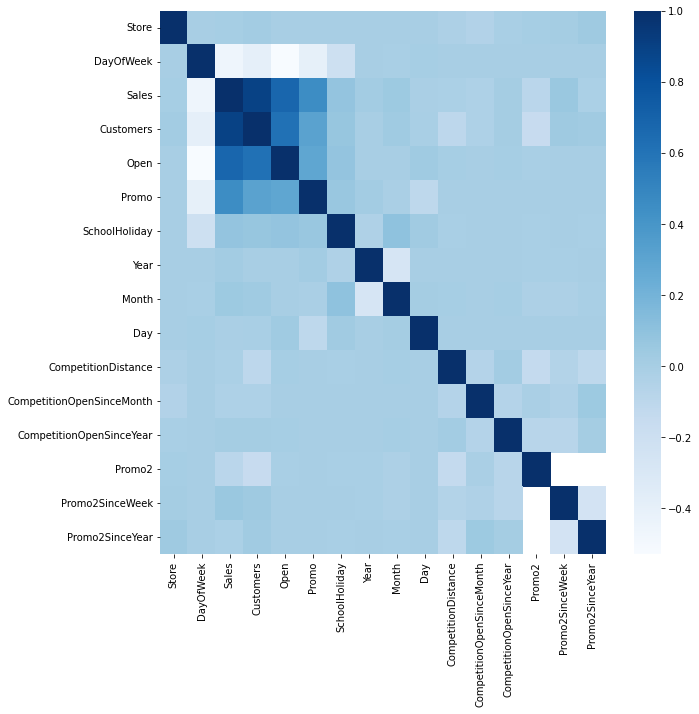

In [22]:
#Creating a correlation matrix 
cordata=dataset[['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']]
corr = cordata.corr()
fig= plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap="Blues", annot=False)

**Findings: Here we dont see much multicollinearity in the dataset, so we will be skipping the VIF analysis.**

Let us understand the correlation of all the features with out target variable (**SALES**) in a more clear way.

In [23]:
# Getting correlation details w.r.t Sales.
correlations = dataset.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.462125
Promo2                      -0.091040
index                       -0.041906
CompetitionOpenSinceMonth   -0.028257
Promo2SinceYear             -0.021127
CompetitionDistance         -0.018869
Day                         -0.011612
Store                        0.005126
CompetitionOpenSinceYear     0.012659
Year                         0.023519
Month                        0.048768
Promo2SinceWeek              0.059558
SchoolHoliday                0.085124
Promo                        0.452345
Open                         0.678472
Customers                    0.894711
Sales                        1.000000
Name: Sales, dtype: float64

**Observations:**

* Here we can see some clear correlations between sales and some other features. These features are Customers, Open, Promo, SchoolHoliday. All the above mentioned features share a positive relation with Sales. 

* There are a few features, which show a negative relation with Sales viz. Promo2 and DayofWeek. We shall inspect them in the upcoming analysis.

***As per ISO 8601 Monday should be the first day of the week. In US, Canada and Japan, Monday is considered as the second day. The present data follows ISO standards as the first date 15-7-31 in the table represents the 5th day i.e. Friday.***

# **Exploratory Data Analysis**

**1. CUSTOMERS VS SALES:**

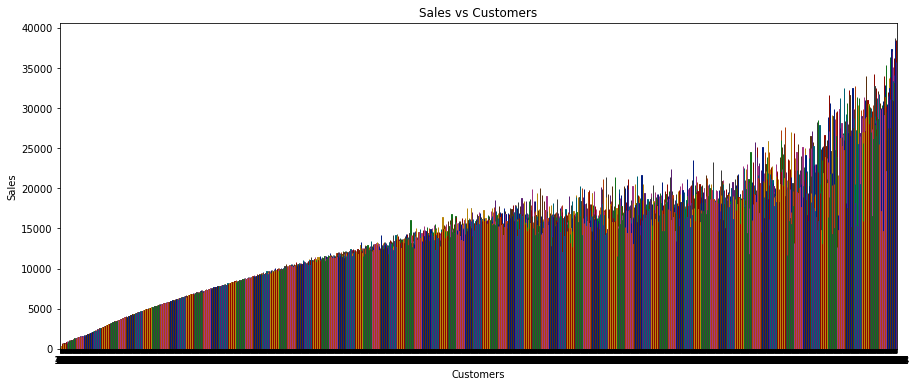

In [24]:
# Plotting Customer vs Sales by taking mean of sales.
plt.subplots(figsize=(15,6))
cus = rs_data.groupby('Customers').Sales.mean().to_frame().reset_index()
cus.columns = ['Customers','Sales']
sns.barplot(x=cus.Customers, y=cus.Sales, palette='RdYlGn_r',edgecolor=sns.color_palette('dark',10))
plt.title('Sales vs Customers')
plt.show()  

**Findings:**

* It is easy to spot that the graph shows a positive growth in the overall trend. As the number of customers increase, the number of sales also increase.

---
* We can observe another pattern in the graph as the number of customers increase. We can see a bit of distortion or uneven number of sales while the customers are increasing in number. This can be due to the price of the products being sold in the store. We will be able to verify this hypothesis while studying the promo features.


---


* This can be our null hypothesis:


**H0 = Sales of the products are higher with a promotional offer.**


**2. PROMO VS SALES & PROMO VS CUSTOMERS :**

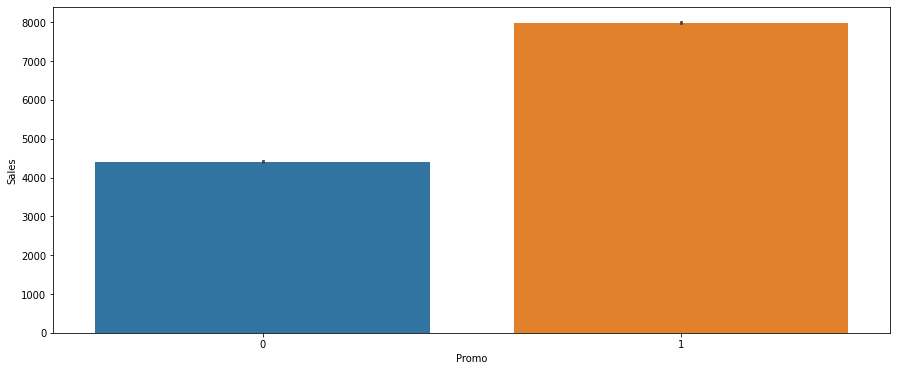

In [25]:
# Plotting Promo vs sales
plt.subplots(figsize=(15,6))
sns.barplot(x='Promo', y='Sales', data=rs_data)

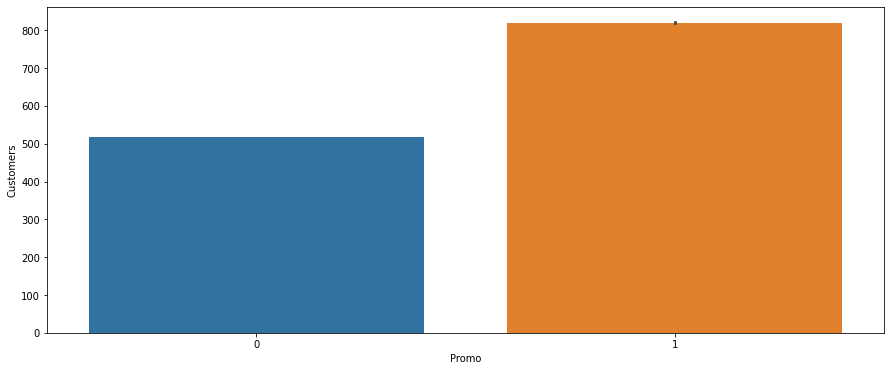

In [26]:
# Plotting Promo vs Customers
plt.subplots(figsize=(15,6))
sns.barplot(x='Promo', y='Customers', data=rs_data)

**Findings**:

* We can see that both, 'Customers' and 'Sales' show a higher number when the promotional offer is active. Hence, we **Failed to Reject the Hypothesis** for now.

* Let us understand the realtion between the second promotional offer (Promo2) that was active, and check if the above relation holds up.

**3. PROMO2 VS SALES & PROMO2 VS CUSTOMERS :**

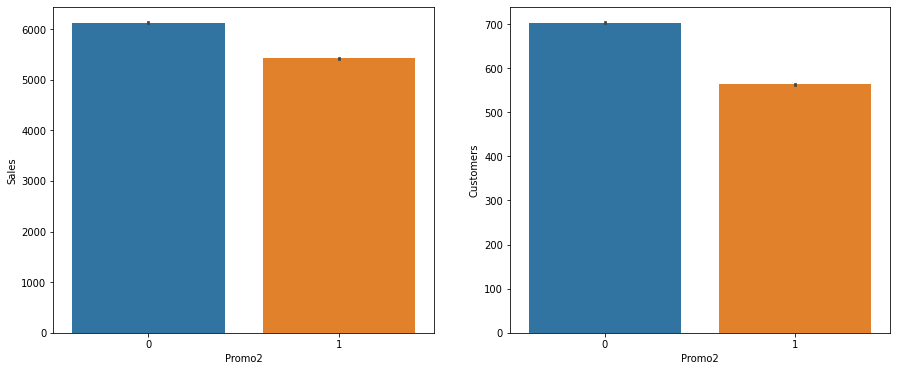

In [27]:
# Plotting Promo2 vs Sales and Promo2 vs Customers.
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,6))
sns.barplot(x='Promo2', y='Sales', data=dataset, ax=axis1)
sns.barplot(x='Promo2', y='Customers', data=dataset, ax=axis2)

**Findings** :

*  Here we can see that both customers and sales value are marginally lower with the promotional offer (Promo2) active.

*  Here we can safelty **reject the null hypothesis** that says, Sales are Higher with a active promotional offer. Perhaps there are more factors affecting the sales.

Now let us move towards the shops' operation time.

**4. No. of SHOPS OPEN vs WEEKDAYS :** 

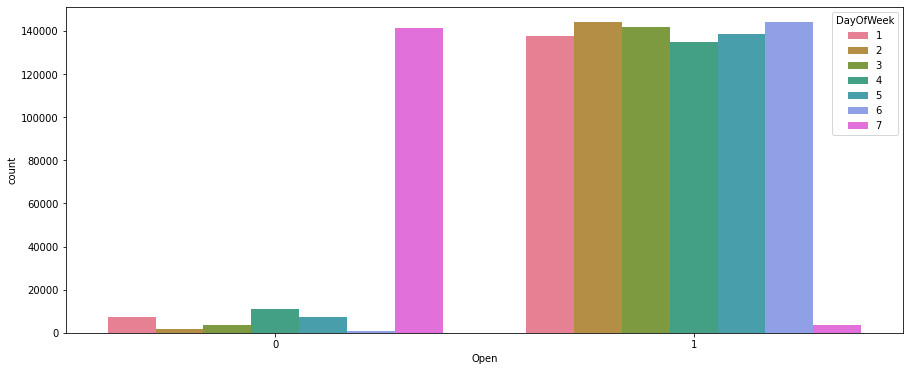

In [28]:
# Getting a summary of operational days of shops.
plt.subplots(figsize=(15,6))
sns.countplot(x='Open',hue='DayOfWeek', data=dataset,palette="husl")

**Findings:**

* We can observe that most of the shops are open on the weekdays and closed on Sundays.
* The little amount of shops that are closed on the weekdays might be due to the mentioned fact that, they are under refurbishment phase.

---



School Holidays are also a feature showing a significant positive relation with Sales of the stores. We shall find out what is affecting the sales here.



**5. No. of Shops Affected by School Holiday vs School Holidays :**

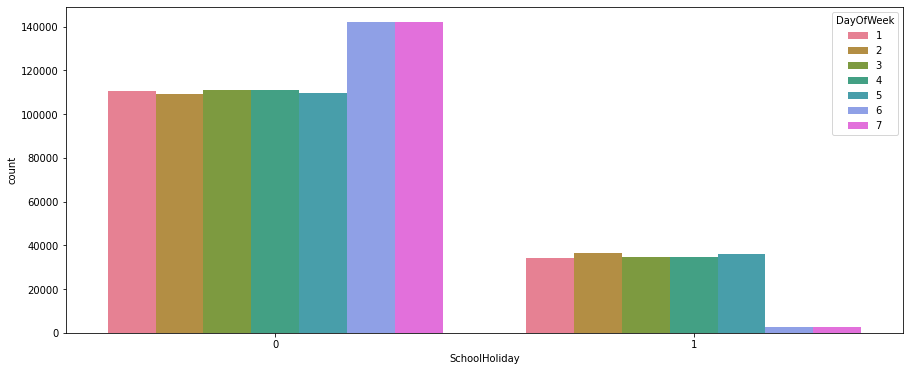

In [29]:
# Analysing the effects of School Holiday on Stores.
plt.subplots(figsize=(15,6))
sns.countplot(x='SchoolHoliday',hue='DayOfWeek', data=dataset,palette="husl")

Here, School Holiday shows us if the Store was affected by the closure of the School. **'1'** means the store was affected, while **'0'** means the store was not affected by the closure of the school.


**Findings** 

* Comparing the above two charts we can see that the stores were not much affected on Saturday and Sunday as they we also closed along with the school.

* Here we can also see that the stores were affected by the closure of the School on weekdays. It affects less than 1/3rd stores of the whole. 

* Here a positive correlation means, the sales of the stores should increase if the Schools are closed.

**6. SCHOOL HOLIDAY VS SALES :**

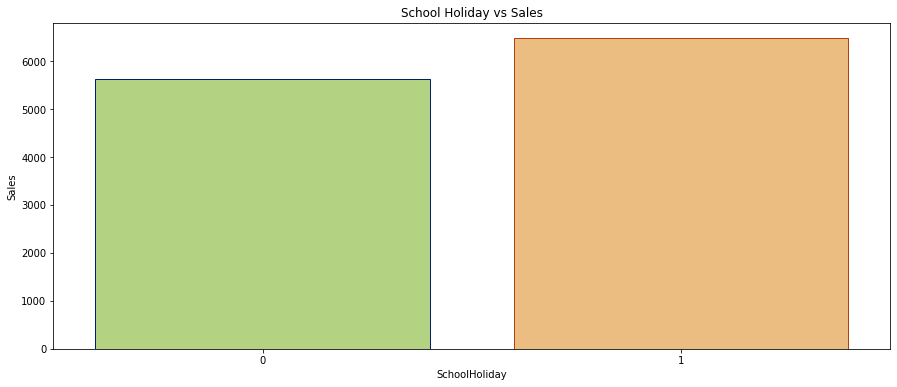

In [30]:
# Plot for getting the Sales vs School Holiday graph.
plt.subplots(figsize=(15,6))
cus = rs_data.groupby('SchoolHoliday').Sales.mean().to_frame().reset_index()
cus.columns = ['SchoolHoliday','Sales']
sns.barplot(x=cus.SchoolHoliday, y=cus.Sales, palette='RdYlGn_r',edgecolor=sns.color_palette('dark',10))
plt.title('School Holiday vs Sales')
plt.show()  

**Findings** 

* When the stores are affected due to school holidays, we see a higher sales number. This might be due to the weekend, when people come out for shopping and refilling their essentials.

* Here we can say that School Holidays and Sales are positively related in some sense.

---



Now that we know what are the major factors affecting the sales of the stores, let us understand the types of stores and their significance.

**7. STORETYPES VS NO. OF STORES :**

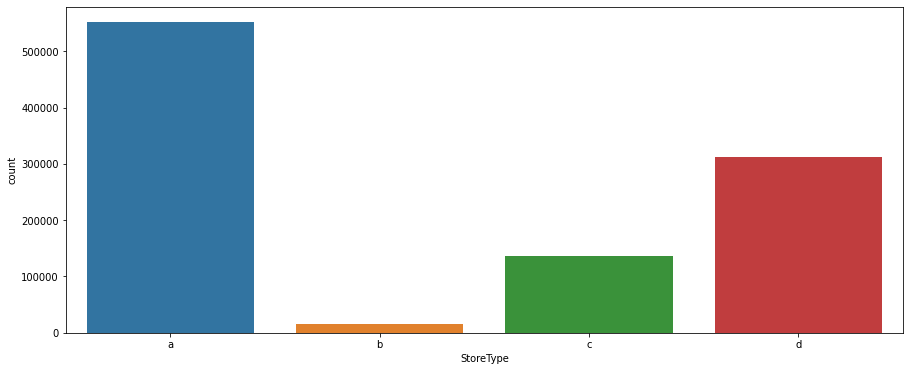

In [31]:
# Plot to understand the number of stores of each type present.
plt.subplots(figsize=(15,6))
sns.countplot(x='StoreType', data=dataset, order=['a','b','c', 'd'])

We have four types of stores a,b,c and d. We can see there are many outlets for the type 'a' followed by d,c and b respectively. 'b' having the least number of stores.

**8. STORETYPE VS NO.OF CUSTOMERS :**

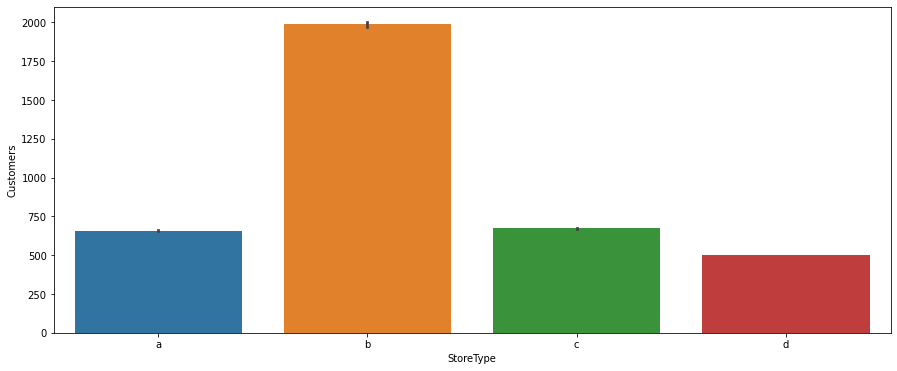

In [32]:
# Plotting Relation between Store type and its customers.
plt.subplots(figsize=(15,6))
sns.barplot(x='StoreType', y='Customers', data=dataset, order=['a','b','c', 'd'])

The number of customers coming in the store type 'b' are immense as compared to the others. This indicates that either the store type 'b' is a superstore or a wholesale/company outlet. 

**9. STORETYPE VS SALES :**

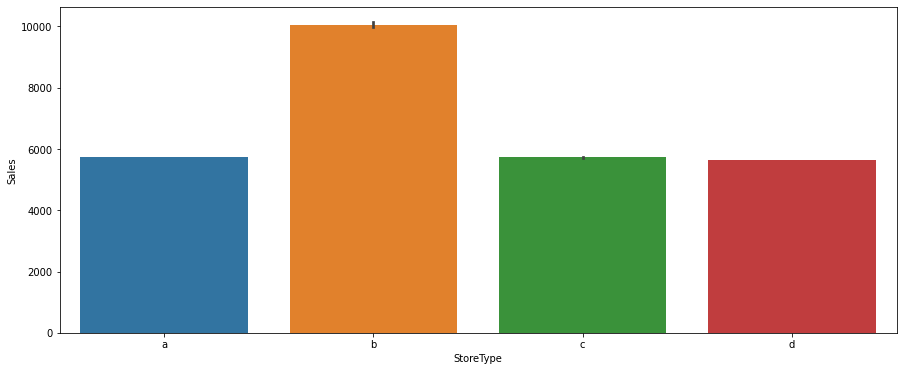

In [33]:
# Getting the sales numbers for each type of store.
plt.subplots(figsize=(15,6))
sns.barplot(x='StoreType', y='Sales', data=dataset, order=['a','b','c', 'd'])

**Findings:** 

* This above chart is totally opposite to the first one, as it shows the most amount of sales happening from the store 'b' which has the least number of outlets. 
* This may be a direct company outlet or a superstore of some kind to have so much sales. 

---



We shall now see the assortment type of the store and its relevant data. This will give us an insight in what type of stores should be opened in new places and which will work more effectively.

Assortment Types:

**a**:Basic Store

**b**:Extra Store

**c**:Extended Store

**10. ASSORTMENT TYPE VS NO. OF STORES :**

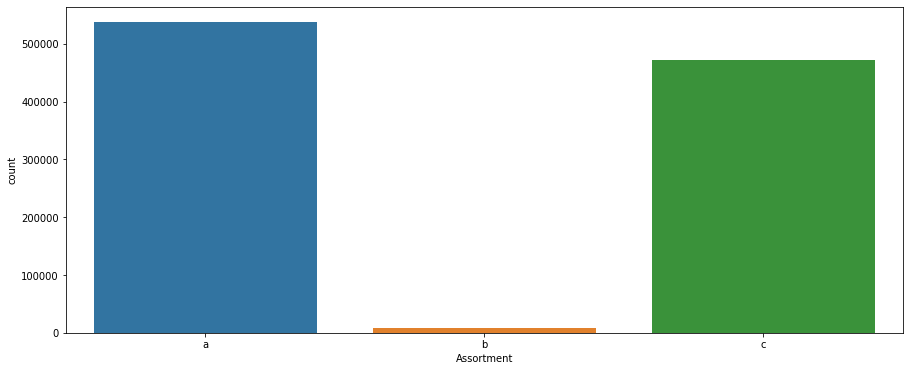

In [34]:
# Finding the number of stores for each assortment type.
plt.subplots(figsize=(15,6))
sns.countplot(x='Assortment', data=dataset, order=['a','b','c'])

**Findings:**

* Basic Stores i.e. Assortment type 'a' have the most number of outlets. It makes sense by business point of view to have the essentials widely available.

* The Extra Stores i.e. Assortment type 'b' have the least number of outlets. Extra stuff cannot be made available on each basic store as it will take up inventory space and might not even sell with high frequency.

* Extended Stores i.e. Assortment type 'c' have the second highest number of outlets.

**11. ASSORTMENT TYPE VS CUSTOMERS :**

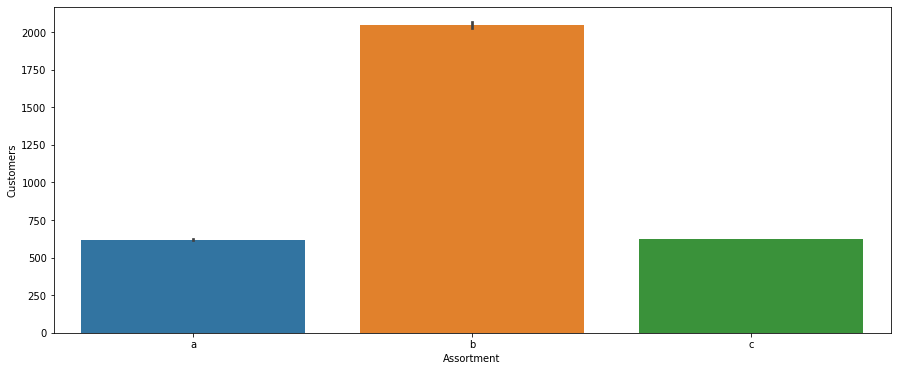

In [35]:
# Plot for Assortment type vs no. of customers.
plt.subplots(figsize=(15,6))
sns.barplot(x='Assortment', y='Customers', data=dataset, order=['a','b','c'])

**Assumption :**

* Assortment type 'b' i.e. Extra, is attracting the most number of customers in the shops. This probably might be due to the availability of everything in one stop.

**12. ASSORTMENT TYPE VS SALES :**

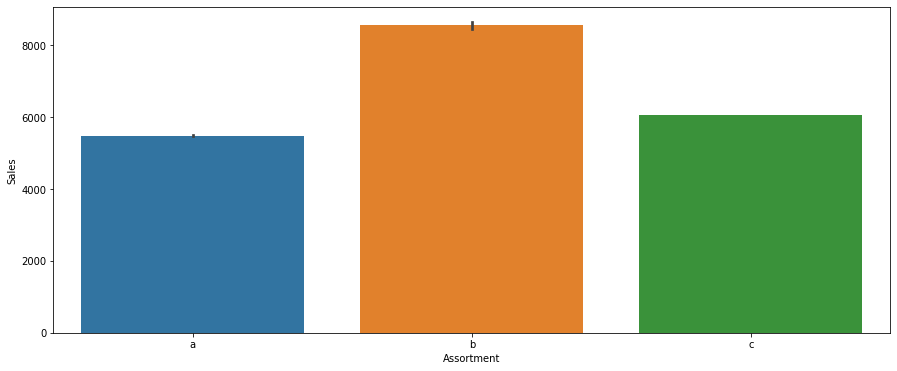

In [36]:
# Plot for Sales vs Assortment Type.
plt.subplots(figsize=(15,6))
sns.barplot(x='Assortment', y='Sales', data=dataset, order=['a','b','c'])


**Findings:**

* The sales chart follows the path of customer vs assortment chart as above. 

* There is an interesting thing that we can observe here. The sales to customers ratio of assortment type 'a' and 'c' is significantly higher as compared to assortment type 'b'. 

* Same customers with high frequency of sales is what assortment 'a' and 'c' seem to be targeting.



---

We now, need to understand the relation between the Competetion distance and Sales of the stores, as it also showed some positive correlation in the previous analysis.

**13. COMPETETION DISTANCE VS SALES :**

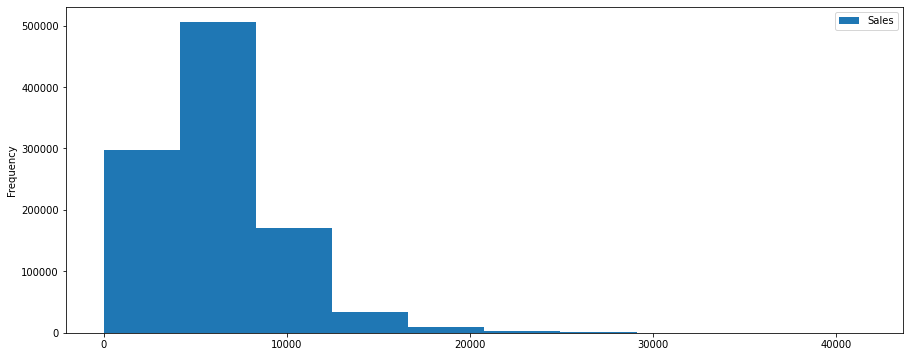

In [37]:
# Understanding the relation between competetion distance and sales.
dataset.plot(kind='hist',x='CompetitionDistance',y='Sales',figsize=(15,6))

**Findings:**

* Looking at the histogram we can understand that the distance between competetion matters. Here the relation is not linear. As the distance between stores/competetions increases, the sales happen to increase, but this changes post 8000m mark. 
* Distances higher than 10000 show a decline in the sales, this may be indicating the stores located in the remote areas with less population.

Let us see, how the distribution of the Sales and Customers is.

**14. SALES AND CUSTOMER DISTRIBUTION :**

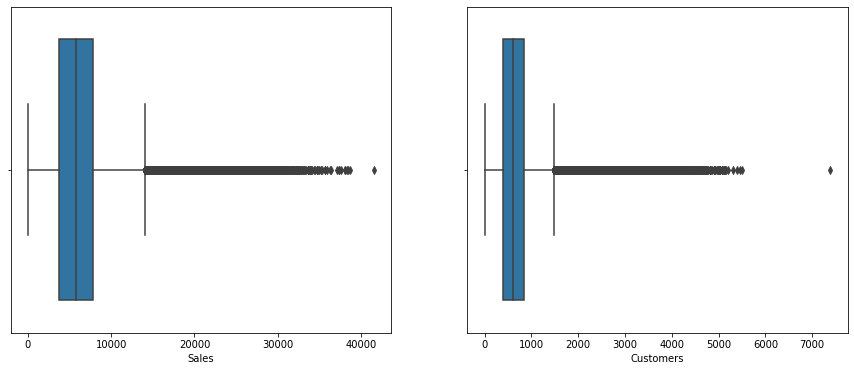

In [38]:
# Plotting Box Plots to get the distribution of Sales and Customers.
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,6))
sns.boxplot(x= rs_data["Sales"],ax=axis1)
sns.boxplot(x= rs_data["Customers"],ax=axis2)

# **Findings:**
1.   There is an obvious and major correlation between sales and customers, which suggests that the customers tend to buy something or the other before leaving the store. There are some undulations with higher number of customers vs sales.
2.   The undulations in the higher number of customers vs sales are not due to price of the products, which we figured out by Hypothesis testing. We tried to understand the relation of Sales with Promo and Promo2.



# **Feature Engineering:**

* From the above EDA we understood the correlation between various features and Sales.
*  Now in order to train a ML model, we will be needing numerical values.
* We will be dropping some features which did not show much correlation with Sales and creating dummies with categorical features.

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   index                      1017209 non-null  int64  
 1   Store                      1017209 non-null  int64  
 2   DayOfWeek                  1017209 non-null  int64  
 3   Date                       1017209 non-null  object 
 4   Sales                      1017209 non-null  int64  
 5   Customers                  1017209 non-null  int64  
 6   Open                       1017209 non-null  int64  
 7   Promo                      1017209 non-null  int64  
 8   StateHoliday               1017209 non-null  object 
 9   SchoolHoliday              1017209 non-null  int64  
 10  Year                       1017209 non-null  int64  
 11  Month                      1017209 non-null  int64  
 12  Day                        1017209 non-null  int64  
 13  StoreType   

In [40]:
dataset.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [41]:
# Dropping the features/ columns which do not have much positive or negative correlation with the target feature.
dataset=dataset.drop(['index', 'Store','Date','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval'], axis=1)

In [42]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   DayOfWeek            1017209 non-null  int64  
 1   Sales                1017209 non-null  int64  
 2   Customers            1017209 non-null  int64  
 3   Open                 1017209 non-null  int64  
 4   Promo                1017209 non-null  int64  
 5   StateHoliday         1017209 non-null  object 
 6   SchoolHoliday        1017209 non-null  int64  
 7   Year                 1017209 non-null  int64  
 8   Month                1017209 non-null  int64  
 9   Day                  1017209 non-null  int64  
 10  StoreType            1017209 non-null  object 
 11  Assortment           1017209 non-null  object 
 12  CompetitionDistance  1017209 non-null  float64
 13  Promo2               1017209 non-null  int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 

* ***StateHoliday feature has categorical features a,b,c and a numerical feature 0. Let us convert all of them in the same type.***

In [43]:
# Here we only need to know if there is a State Holiday or not, so we are mapping them to 0 and 1.
dataset['StateHoliday'] = dataset.StateHoliday.map({np.nan: 0 ,0: 0,'0':0, 'a':1 ,'b' : 1,'c': 1})

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   DayOfWeek            1017209 non-null  int64  
 1   Sales                1017209 non-null  int64  
 2   Customers            1017209 non-null  int64  
 3   Open                 1017209 non-null  int64  
 4   Promo                1017209 non-null  int64  
 5   StateHoliday         1017209 non-null  int64  
 6   SchoolHoliday        1017209 non-null  int64  
 7   Year                 1017209 non-null  int64  
 8   Month                1017209 non-null  int64  
 9   Day                  1017209 non-null  int64  
 10  StoreType            1017209 non-null  object 
 11  Assortment           1017209 non-null  object 
 12  CompetitionDistance  1017209 non-null  float64
 13  Promo2               1017209 non-null  int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 

In [45]:
# Removing Store data with zero sales
dataset=dataset[dataset.Sales != 0]

In [46]:
# Getting dummies for some categorical columns
dataset = pd.get_dummies(dataset,columns=['StoreType','Assortment','Year'])

In [47]:
dataset.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day,CompetitionDistance,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Year_2013,Year_2014,Year_2015
0,5,5263,555,1,1,0,1,7,31,1270.0,0,0,0,1,0,1,0,0,0,0,1
1,5,6064,625,1,1,0,1,7,31,570.0,1,1,0,0,0,1,0,0,0,0,1
2,5,8314,821,1,1,0,1,7,31,14130.0,1,1,0,0,0,1,0,0,0,0,1
3,5,13995,1498,1,1,0,1,7,31,620.0,0,0,0,1,0,0,0,1,0,0,1
4,5,4822,559,1,1,0,1,7,31,29910.0,0,1,0,0,0,1,0,0,0,0,1


In [48]:
# Storing the target variable aside.
dependent_variable = 'Sales'

In [49]:
# Storing the independent variables.
independent_variables = list(set(dataset.columns.tolist()) - {dependent_variable})

In [50]:
independent_variables

['DayOfWeek',
 'Assortment_c',
 'Year_2013',
 'Promo',
 'Month',
 'Open',
 'Promo2',
 'Assortment_a',
 'StoreType_a',
 'Year_2014',
 'Customers',
 'SchoolHoliday',
 'CompetitionDistance',
 'StoreType_b',
 'StateHoliday',
 'Day',
 'StoreType_d',
 'Year_2015',
 'StoreType_c',
 'Assortment_b']

In [51]:
# Create the data of independent variables
X = dataset[independent_variables].values

# Create the dependent variable data
y = dataset[dependent_variable].values

In [52]:
dataset[independent_variables]

,DayOfWeek,Assortment_c,Year_2013,Promo,Month,Open,Promo2,Assortment_a,StoreType_a,Year_2014,Customers,SchoolHoliday,CompetitionDistance,StoreType_b,StateHoliday,Day,StoreType_d,Year_2015,StoreType_c,Assortment_b
0,5,0,0,1,7,1,0,1,0,0,555,1,1270.0,0,0,31,0,1,1,0
1,5,0,0,1,7,1,1,1,1,0,625,1,570.0,0,0,31,0,1,0,0
2,5,0,0,1,7,1,1,1,1,0,821,1,14130.0,0,0,31,0,1,0,0
3,5,1,0,1,7,1,0,0,0,0,1498,1,620.0,0,0,31,0,1,1,0
4,5,0,0,1,7,1,0,1,1,0,559,1,29910.0,0,0,31,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,2,0,1,0,1,1,0,1,0,0,566,1,150.0,1,1,1,0,0,0,0
1016827,2,0,1,0,1,1,0,0,0,0,2377,1,860.0,1,1,1,0,0,0,1
1016863,2,0,1,0,1,1,1,0,0,0,1248,1,840.0,1,1,1,0,0,0,1
1017042,2,0,1,0,1,1,0,0,0,0,1039,1,1430.0,1,1,1,0,0,0,1


In [53]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [54]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
# Creating a function for calculation of Mean Absolute Percenage Error.
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [89]:
# Building a performance calculator to make the code more modular.
# This function will calculate the performance mertics and list them along with the model score.
def Performance(fitname):
  # Model Score
  print("Model Score",fitname.score(X_train, y_train))
  print("Test Model Score",fitname.score(X_test,y_test))

  # Training prediction
  y_pred_train= fitname.predict(X_train)

  # Predicting the Test set results
  y_pred = fitname.predict(X_test)


  # Performance testing with Train and Test Data:
  # MSE
  print("Train Performance MSE",mean_squared_error(y_train, y_pred_train))
  print("Test Performance MSE",mean_squared_error(y_test, y_pred))

  #RMSE
  print("Train Performance RMSE",math.sqrt(mean_squared_error(y_train, y_pred_train)))
  print("Test Performance RMSE",math.sqrt(mean_squared_error(y_test, y_pred)))

  #MAPE
  print("Train Performance MAPE", MAPE(y_train,y_pred_train))
  print("Test Performance MAPE", MAPE(y_test,y_pred))

# Linear Regression

In [92]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)
Performance(regressor)

Model Score 0.8257783272429787
Test Model Score 0.8235791850630394
Train Performance MSE 1677142.1399662457
Test Performance MSE 1704638.7764407704
Train Performance RMSE 1295.0452269964342
Test Performance RMSE 1305.6181587435012
Train Performance MAPE 14.438217298249494
Test Performance MAPE 14.45854165325981


# Lasso Regression

In [93]:
# Lasso Regression
lasso  = Lasso(alpha=0.02 , fit_intercept=False, normalize=True)
lasso.fit(X_train, y_train)
Performance(lasso)

Model Score 0.8257868370616624
Test Model Score 0.823596798869152
Train Performance MSE 1677060.2203331024
Test Performance MSE 1704468.5857696128
Train Performance RMSE 1295.013598512812
Test Performance RMSE 1305.5529808359418
Train Performance MAPE 14.433368302321679
Test Performance MAPE 14.45343876022594


In [95]:
# Tried a different alpha value of 0.1
lasso  = Lasso(alpha=0.03 , fit_intercept=False, normalize=True)
lasso.fit(X_train, y_train)
Performance(lasso)

Model Score 0.82578675127039
Test Model Score 0.8235969158320383
Train Performance MSE 1677061.046201411
Test Performance MSE 1704467.4556338554
Train Performance RMSE 1295.0139173774971
Test Performance RMSE 1305.5525480170668
Train Performance MAPE 14.433466810812606
Test Performance MAPE 14.453542150217297


***The performance did not optimize much after the Hyperparameter tuning, but more the merrier. The testing errors tend to reduce a little but the training errors have increased in the same way.***

**NOTE**- Here, we tried bunch of alpha values with minor differences, but kept the first and last one only.

# Ridge Regression

In [96]:
# Ridge Regression
ridge = Ridge(alpha=0.1)
ridreg=ridge.fit(X_train, y_train)
Performance(ridge)

Model Score 0.8257869046173363
Test Model Score 0.8235967513004934
Train Performance MSE 1677059.5700094905
Test Performance MSE 1704469.045394403
Train Performance RMSE 1295.0133474252266
Test Performance RMSE 1305.5531568627923
Train Performance MAPE 14.433330334020104
Test Performance MAPE 14.453388864999198


In [98]:
ridge = Ridge(alpha=0.08)
ridreg=ridge.fit(X_train, y_train)
Performance(ridge)

Model Score 0.8257869050051683
Test Model Score 0.8235966914917424
Train Performance MSE 1677059.5662760322
Test Performance MSE 1704469.6232871888
Train Performance RMSE 1295.0133459837518
Test Performance RMSE 1305.5533781838217
Train Performance MAPE 14.433299134621237
Test Performance MAPE 14.453357910019719


***Even here the performance does not change much with some simple tuning with the alpha values. Minor reduction in errors can be observed in the testing phase.***

**NOTE**- Here, we tried bunch of alpha values with minor differences, but kept the first and last one only.

# Decision Tree Regression Model

In [99]:
# Decision Tree Regression
tree_regressor = DecisionTreeRegressor(min_samples_leaf=20, random_state=0)
trreg=tree_regressor.fit(X_train, y_train)
Performance(trreg)

Model Score 0.9532514254641122
Test Model Score 0.9397726050707584
Train Performance MSE 450024.4033750992
Test Performance MSE 581937.867349057
Train Performance RMSE 670.8385822052121
Test Performance RMSE 762.8485218895406
Train Performance MAPE 6.437950255802925
Test Performance MAPE 7.243983480853995


# **Selection of a Model:**

# Linear Regression :
**MODEL SCORE:  0.8257783272429787**

Test Model Score 0.8235791850630394

Train Performance MAPE 14.438217298249494

Test Performance MAPE 14.45854165325981


# Lasso Regression :
**MODEL SCORE:  0.82578675127039**

Test Model Score 0.8235969158320383

Train Performance MAPE 14.433466810812606

Test Performance MAPE 14.453542150217297

# Ridge Regression :
**MODEL SCORE:  0.8257869050051683**

Test Model Score 0.8235966914917424

Train Performance MAPE 14.433299134621237

Test Performance MAPE 14.453357910019719

# Decision Tree Regression :
**MODEL SCORE:  0.9532514254641122**

Test Model Score 0.9397726050707584

Train Performance MAPE 6.437950255802925

Test Performance MAPE 7.243983480853995


# **Highest Scoring Model: Decision Tree Regression Model**
**The highest scoring and best fitting model we found out is Decision Tree Regression model. The model scored 0.9532 in the training phase whereas the testing phase model score is 0.9397.**

**Following are the error scores of the model with different evaluation metrics:**
* Train Performance MSE 450024.4033750992
* Test Performance MSE 581937.867349057
* Train Performance RMSE 670.8385822052121
* Test Performance RMSE 762.8485218895406
* Train Performance MAPE 6.437950255802925
* Test Performance MAPE 7.243983480853995

In [108]:
# Getting the feature importances.
tree_regressor.feature_importances_

array([1.01358979e-02, 3.19217446e-03, 6.77330053e-04, 3.65116284e-02,
       3.66964002e-03, 0.00000000e+00, 8.02547384e-03, 2.75354085e-03,
       2.17175292e-03, 1.22913128e-04, 7.74415215e-01, 1.49335559e-04,
       8.18924980e-02, 6.62255918e-03, 1.01567170e-04, 2.03694671e-03,
       4.53268773e-02, 7.31984806e-04, 1.72237681e-03, 1.97402879e-02])

In [120]:
# Mapping the feature importance with their indices.
feature_importance = pd.DataFrame({'Feature':independent_variables,
                                   'Score':tree_regressor.feature_importances_}).sort_values(by='Score', ascending=False).reset_index(drop=True)

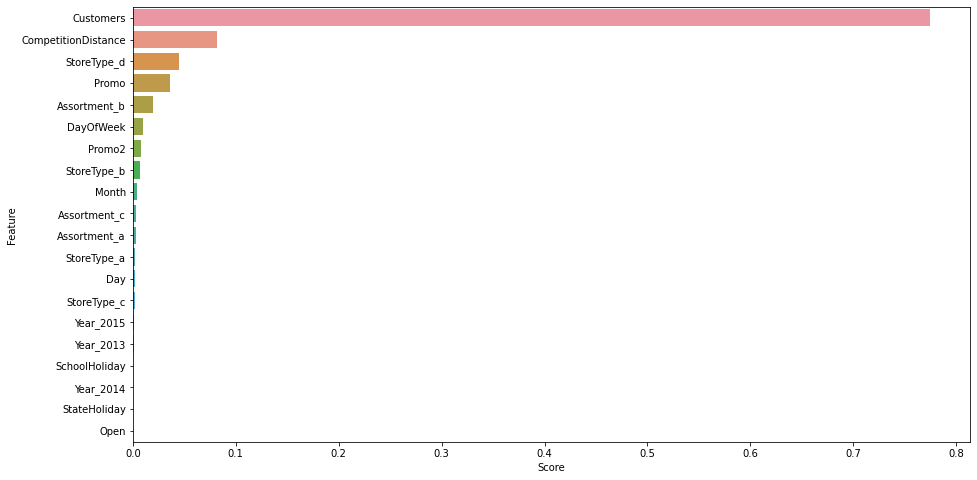

In [122]:
# Plotting the calculated feature importances.
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=feature_importance['Score'], y=feature_importance['Feature'])
plt.show()

**The above chart shows the most important features for this learning, along with their importance values ranging between 0 and 1.**

# **Key Findings:**


We started the experiment by doing some basic data handling, manipulation and null value treatment where needed.
The data came in two different sets. The first data set consisted of basic store details such as the sales, customers and other day to day data.
The second dataset consisted of some more crucial data regarding the competetion, promotional offers, store types, assortment types etc.
Combining both the datasets gave a more better understanding of the bigger picture. 

We checked for multi-colinearity in the dataset, but there were no significantly realted features.

# **EDA Findings:**
1.There are no significant customers going back from the stores, i.e. the customers coming in the store end up buying something.
We see a fairly linear growth in terms of customers and sales.

2.Promotions help in bringing in the customers, but it does not drive the sales as much. We saw two promotions where the first one increased the sales,
whereas the other did'nt really help the sales.

3.Majority of the stores are closed on Sundays. School Holidays, which also happen to be on the weekends drive the sales of the stores.
We see an increase in the sales by the end of the week.

4.There are 4 types of stores, with 3 different types of assortments. The basic stores and extended stores
 tend to maintain the no. of customers and sales over the period. Whereas the Extra stores, seem to gather a whole lot of sales and customer numbers but
do not maintain consistency.

# **Utility functions:**

Further in the machine learning modules we examined the models based on some evaluation metrics, one of which was Mean Absolute Percentage Error.
We ended up creating a function called **MAPE()** for the same.

The second utility function that we created was to test the performance of the models we have used. I created a function called **Performance(model_fit)**
This utility function takes in the model fit name that we used, and gives out certain metrics about the newly generated model.
* Model Score 
* Test Model Score 
* Train Performance MSE 
* Test Performance MSE 
* Train Performance RMSE 
* Test Performance RMSE 
* Train Performance MAPE 
* Test Performance MAPE 

These are the metrics that the utility function calculates and presents as a report.


# **Findings of ML models:**

The target variable that we are focusing on is a continuous variable (Sales). Here, regression models would work best.
We selected to work with four of the most finest regression models.
* Linear Regression
* Lasso Regression
* Ridge Regression
* Decision Tree Regressor

After splitting the data into Train and Test datasets, we performed fitting of the above mentioned models, and these were the results-


**Linear Regression :
MODEL SCORE: 0.8257**

Test Model Score 0.8235791850630394

Train Performance MAPE 14.438217298249494

Test Performance MAPE 14.45854165325981

**Lasso Regression :
MODEL SCORE: 0.8257**

Test Model Score 0.8235969158320383

Train Performance MAPE 14.433466810812606

Test Performance MAPE 14.453542150217297

**Ridge Regression :
MODEL SCORE: 0.8257**

Test Model Score 0.8235966914917424

Train Performance MAPE 14.433299134621237

Test Performance MAPE 14.453357910019719

**Decision Tree Regression :
MODEL SCORE: 0.9532**

Test Model Score 0.9397726050707584

Train Performance MAPE 6.437950255802925

Test Performance MAPE 7.243983480853995

**Decision Tree Regressor** turned out to be the best fitting model out of all we tested. Even after doing some Hyperparameter tuning with Lasso and Ridge regression
models, we could not achieve this level of score with either.

The top features that affect the sales are-
* Customers
* Competetion Distance
* Promo
* Store Type 
* Assortment Type
* Day of Week



